# Figure 2: False Positives - Large dataset of noise

First, a dataset of 100,000 trajectories of length 500 with noise of size 100 will be generated. This will then be searched for changepoints at various confidence thresholds, and the rates of false positives determined as a function of position for each confidence threshold. This requires Python 3, Julia v0.6 and R, including the specified Python and R libraries, as well as the change point source file for Julia. Imporantly, it also requires Jupyter notebook kernels for R and Julia be installed.

## Python 3 Kernel - Trajectory Simulation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import beadpy
import pandas as pd
import itertools

In [2]:
random.seed(53)

In [3]:
def nocpt(duration, noise, ntrajectories):
    position = [0]*duration*ntrajectories
    nucleotides = np.array(position) + np.random.normal(loc=0, scale = noise, size = duration*ntrajectories)
    time = list(range(duration))*ntrajectories
    trajectory = np.repeat(range(0,ntrajectories),duration)
    results = pd.DataFrame({'time' : time,
                           'nucleotides' : nucleotides,
                           'trajectory' : trajectory})
    return results;
        

In [4]:
data = nocpt(500, 100, 100000)

In [5]:
data.to_csv('nocpt_100000.csv', index = False, columns=['time', 'nucleotides', 'trajectory'])

## Julia 0.6 Kernel - Change Point Analysis

Now switch to a Julia 0.6 kernel, and import the kinetic change point functions.

In [1]:
include("../src/KineticChangepoints.jl")

getchangepoints (generic function with 3 methods)

Get the change points at a few difference confidence levels. This function is explained in the notebook contained in the 'examples' folder.

In [2]:
getchangepoints("nocpt_100000.csv", "segments69.csv", 100, 0.69, ',', [1, 2, 3]);

In [3]:
getchangepoints("nocpt_100000.csv", "segments90.csv", 100, 0.90, ',', [1, 2, 3]);

In [4]:
getchangepoints("nocpt_100000.csv", "segments95.csv", 100, 0.95, ',', [1, 2, 3]);

In [5]:
getchangepoints("nocpt_100000.csv", "segments99.csv", 100, 0.99, ',', [1, 2, 3]);

## R Kernel - Analysis and Plots

Now switch to an R kernel and import the segments tables.

In [1]:
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(svglite)))

In [2]:
cptsegments99 <- suppressWarnings(suppressMessages(read_csv("segments99.csv")))
cptsegments95 <- suppressWarnings(suppressMessages(read_csv("segments95.csv")))
cptsegments90 <- suppressWarnings(suppressMessages(read_csv("segments90.csv")))
cptsegments69 <- suppressWarnings(suppressMessages(read_csv("segments69.csv")))

In [3]:
falsepos99 <- cptsegments99 %>% filter(x1 != 0) %>% mutate(confidence = 99)
falsepos95 <- cptsegments95 %>% filter(x1 != 0) %>% mutate(confidence = 95)
falsepos90 <- cptsegments90 %>% filter(x1 != 0) %>% mutate(confidence = 90)
falsepos69 <- cptsegments69 %>% filter(x1 != 0) %>% mutate(confidence = 69)

In [4]:
falseposminiframe <- bind_rows(falsepos99,falsepos95,falsepos90,falsepos69)

In [5]:
falsepos69_2 <- falsepos69 %>% group_by(x1) %>% summarise(count69 = n())
falsepos69_2$x1 <- factor(falsepos69_2$x1, levels = seq(2,496))
falsepos90_2 <- falsepos90 %>% group_by(x1) %>% summarise(count90 = n())
falsepos90_2$x1 <- factor(falsepos90_2$x1, levels = seq(2,496))
falsepos95_2 <- falsepos95 %>% group_by(x1) %>% summarise(count95 = n())
falsepos95_2$x1 <- factor(falsepos95_2$x1, levels = seq(2,496))
falsepos99_2 <- falsepos99 %>% group_by(x1) %>% summarise(count99 = n())
falsepos99_2$x1 <- factor(falsepos99_2$x1, levels = seq(2,496))
falsepos99_2 <- falsepos99_2 %>% complete(x1)
falsepos99_2$count99[is.na(falsepos99_2$count99)] <- 0
falsepos <- left_join(falsepos69_2, falsepos90_2, by = "x1")
falsepos <- left_join(falsepos, falsepos95_2, by = "x1")
falsepos <- left_join(falsepos, falsepos99_2, by = "x1")
falsepos <- falsepos %>% gather(threshold, count, -x1)

Find out the rate of false positives at each confidence threshold:

In [6]:
falsepos69_3 <- falsepos69_2 %>%
                summarise(rate = 100*sum(count69)/100000)
falsepos90_3 <- falsepos90_2 %>%
                summarise(rate = 100*sum(count90)/100000)
falsepos95_3 <- falsepos95_2 %>%
                summarise(rate = 100*sum(count95)/100000)
falsepos99_3 <- falsepos99_2 %>%
                summarise(rate = 100*sum(count99)/100000)

Plot false positives as a function of position and confidence threshold.

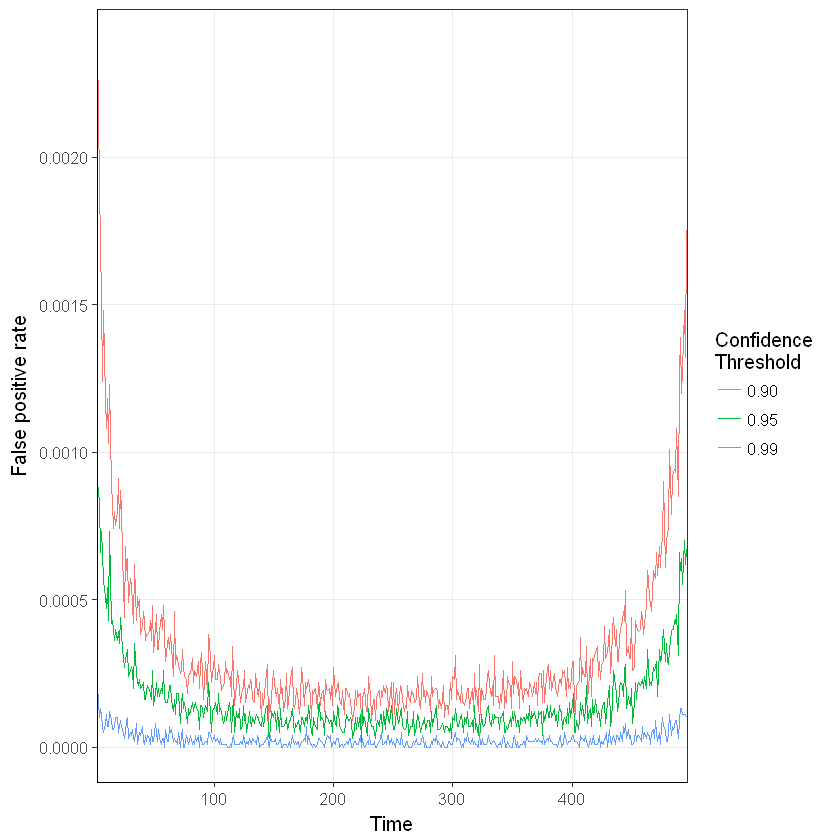

In [7]:
falseposplot <- ggplot(falsepos[falsepos$threshold != 'count69',], aes(x = x1, y = count/100000, group = threshold, colour = threshold))+
                geom_line(size = 0.5)+
                theme_bw(12) + 
                theme(panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+
                scale_x_discrete(breaks=seq(0,500,100), labels =seq(0,500,100))+
                labs(x = "Time", y = "False positive rate")+
                scale_colour_discrete(name="Confidence\nThreshold",labels=c("0.90", "0.95", "0.99"))
falseposplot

Get a publication-ready svg file:

In [8]:
svglite(file = "falseposplot.svg", width = 3.37, height = 2)
falseposplot
dev.off()

png 
  2